In [1]:
import sys
import os
import pandas as pd
import sklearn as sk
import numpy as np
import tensorflow as tf
import platform
import keras
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.4-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) 
[Clang 16.0.6 ]
Pandas 2.2.3
Scikit-Learn 1.5.2
GPU is available


In [2]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import librosa
import librosa.display
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Directory containing the MEL spectrogram images
directory = 'mel_spectrograms3'

# List to store the data
data = []

# Iterate over all files in the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.png'):  # Assuming the spectrograms are in .png format
            file_path = os.path.join(root, file)
            # Extract the genre from the filename (word before the first '.')
            genre = file.split('.')[0]
            # Append the data (filename, genre, file path) to the list
            data.append([file, genre, file_path])

# Create a DataFrame from the data
columns = ['filename', 'genre', 'spectrogram']
df_ms = pd.DataFrame(data, columns=columns)

# Display the first few rows of the DataFrame
print(df_ms.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9981 entries, 0 to 9980
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     9981 non-null   object
 1   genre        9981 non-null   object
 2   spectrogram  9981 non-null   object
dtypes: object(3)
memory usage: 234.1+ KB
None


                  filename genre  \
0  pop.00010_segment_3.png   pop   
1  pop.00077_segment_0.png   pop   
2  pop.00090_segment_2.png   pop   
3  pop.00039_segment_7.png   pop   
4  pop.00004_segment_6.png   pop   

                                     spectrogram  
0  mel_spectrograms3/pop/pop.00010_segment_3.png  
1  mel_spectrograms3/pop/pop.00077_segment_0.png  
2  mel_spectrograms3/pop/pop.00090_segment_2.png  
3  mel_spectrograms3/pop/pop.00039_segment_7.png  
4  mel_spectrograms3/pop/pop.00004_segment_6.png  
                       filename genre  \
count                      9981  9981   
unique                     9981    10   
top     pop.00010_segment_3.png   pop   
freq                          1  1000   

                                          spectrogram  
count                                            9981  
unique                                           9981  
top     mel_spectrograms3/pop/pop.00010_segment_3.png  
freq                                           

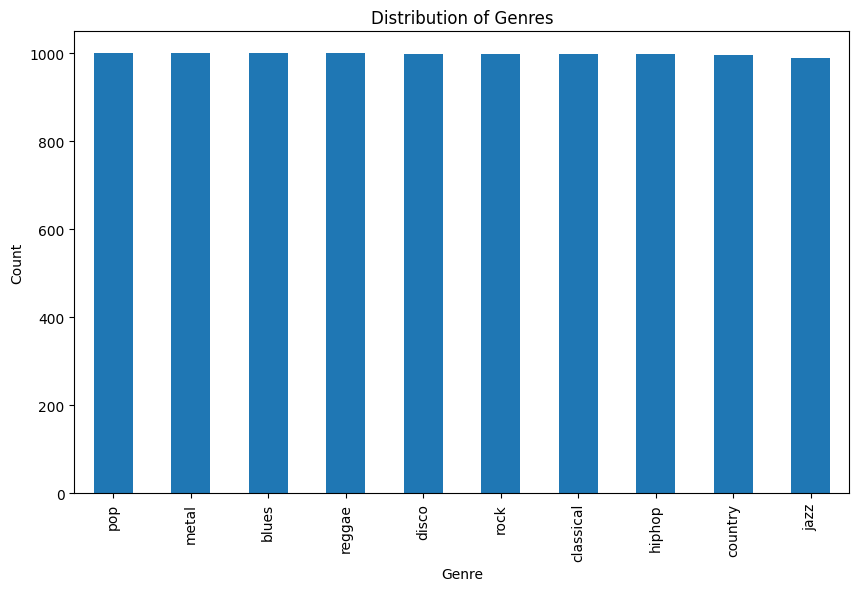

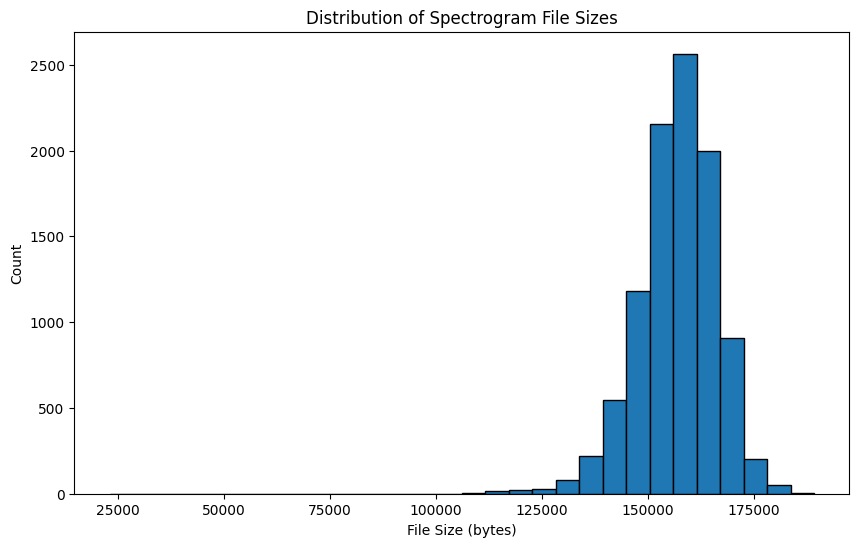

In [4]:
# Display the first few rows of the DataFrame
print(df_ms.head())

# Display basic statistics
print(df_ms.describe())

# Check for missing values
print(df_ms.isnull().sum())

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
df_ms['genre'].value_counts().plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# Plot the distribution of spectrogram file sizes
file_sizes = df_ms['spectrogram'].apply(lambda x: os.path.getsize(x))
plt.figure(figsize=(10, 6))
plt.hist(file_sizes, bins=30, edgecolor='k')
plt.title('Distribution of Spectrogram File Sizes')
plt.xlabel('File Size (bytes)')
plt.ylabel('Count')
plt.show()

In [6]:
# Load an image using PIL
image_path = df_ms['spectrogram'].iloc[3]  # Change the index if you want a different image
image = Image.open(image_path)

# Get the dimensions
width, height = image.size
print(f"Image dimensions: {width}x{height}")

Image dimensions: 387x385


In [13]:

# Initialize ImageDataGenerator with data augmentation for training and validation
datagen_train_val = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
)

# Initialize ImageDataGenerator for testing (no augmentation)
datagen_test = ImageDataGenerator(
    rescale=1./255
)

# Define the target size (ensure it matches your image dimensions)
target_size = (387, 385)  # Example target size, adjust as needed

# Create training generator (80% of the data)
train_generator = datagen_train_val.flow_from_directory(
    directory='mel_spectrograms_split3/train',
    target_size=target_size,
    batch_size=10,
    class_mode='categorical'
)

# Create validation generator (10% of the data)
validation_generator = datagen_train_val.flow_from_directory(
    directory='mel_spectrograms_split3/validation',
    target_size=target_size,
    batch_size=10,
    class_mode='categorical'
)

# Create test generator (10% of the data)
test_generator = datagen_test.flow_from_directory(
    directory='mel_spectrograms_split3/test',
    target_size=target_size,
    batch_size=10,
    class_mode='categorical'
)

Found 7984 images belonging to 10 classes.
Found 998 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(387, 385, 3)),  # First Conv2D layer
    MaxPooling2D((2, 2)),  # First MaxPooling2D layer
    BatchNormalization(),  # First BatchNormalization layer
    Conv2D(62, (3, 3), activation='relu'),  # Second Conv2D layer
    MaxPooling2D((2, 2)),  # Second MaxPooling2D layer
    BatchNormalization(),  # Second BatchNormalization layer
    Conv2D(30, (3, 3), activation='relu'),  # Third Conv2D layer
    MaxPooling2D((2, 2)),  # Third MaxPooling2D layer
    BatchNormalization(),  # Third BatchNormalization layer
    Dropout(0.5),  # Dropout layer
    Flatten(),  # Flatten layer
    Dense(64, activation='relu'),  # Dense layer
    Dense(10, activation='softmax')  # Output layer with 10 classes
])

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where the model will be saved
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the monitored metric
    verbose=1  # Verbosity mode
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with detailed feedback
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/100


2024-11-06 00:21:51.625309: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-06 00:21:51.883164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/499 [=====>........................] - ETA: 2:02 - loss: 2.8322 - accuracy: 0.1609

KeyboardInterrupt: 

7/7 [==============================] - 3s 315ms/step - loss: 2.0592 - accuracy: 0.1881
Test accuracy: 0.1881188154220581


2024-11-05 16:44:16.217510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 633ms/step


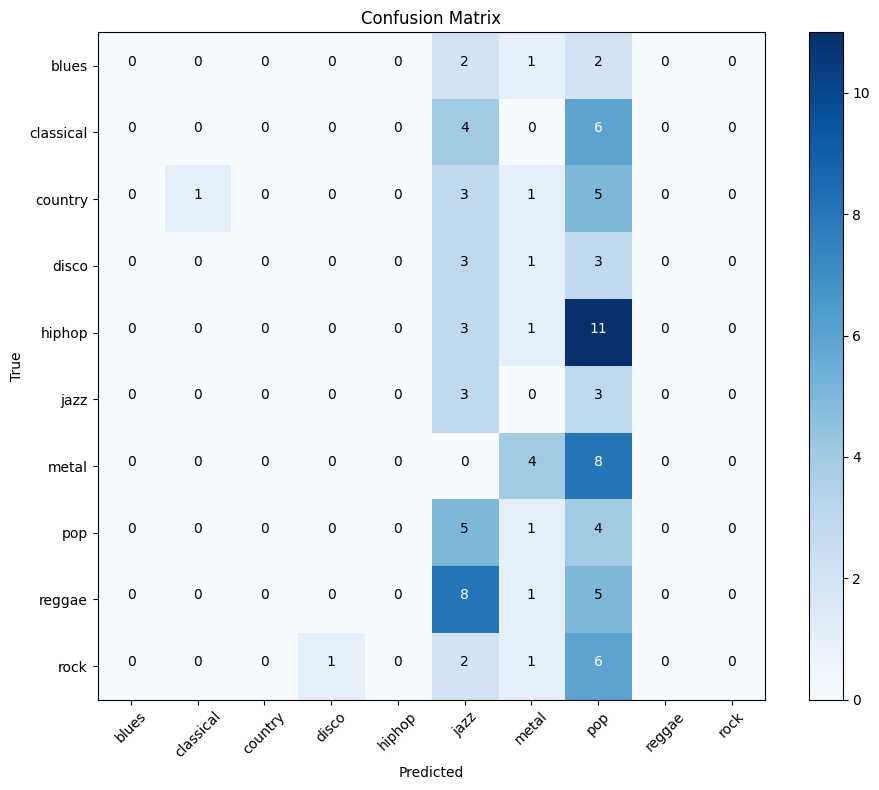

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         5
   classical       0.00      0.00      0.00        10
     country       0.00      0.00      0.00        10
       disco       0.00      0.00      0.00         7
      hiphop       0.00      0.00      0.00        15
        jazz       0.09      0.50      0.15         6
       metal       0.36      0.33      0.35        12
         pop       0.08      0.40      0.13        10
      reggae       0.00      0.00      0.00        14
        rock       0.00      0.00      0.00        10

    accuracy                           0.11        99
   macro avg       0.05      0.12      0.06        99
weighted avg       0.06      0.11      0.06        99



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {accuracy}")

# Predict the classes for the validation data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(validation_generator.class_indices))
plt.xticks(tick_marks, validation_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print(report)